<a href="https://colab.research.google.com/github/Saroj12Dangol/Android-camera-and-gallery/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing required libraries.
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
#from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Conv2DTranspose,Input,Add,UpSampling2D,Dropout,concatenate
from keras.layers import *
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import random
from skimage.io import imread
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_list=os.listdir('/content/drive/MyDrive/Dataset_images (1)')
image_list=[filename.split(".")[0]for filename in image_list]

In [ ]:
def get_segmented_img(img,n_classes):
    """
    Loads in the segmented image and create suitable segmentation label.
    """
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    
    seg_labels[:,:,0]=(img!=0).astype(int)


    return seg_labels

In [ ]:
def preprocess_img(img):
    img=cv2.resize(img,(512,512))
    return img

In [ ]:
def batch_generator(filelist,n_classes,batch_size):
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'/content/drive/MyDrive/Dataset_images (1)/{fn}.png',0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      img=cv2.resize(img,(512,512))
      img=np.expand_dims(img,axis=-1)
      img=img/255

      seg=cv2.imread(f'/content/drive/MyDrive/mask (1)/{fn}.png',1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)

(512, 512)


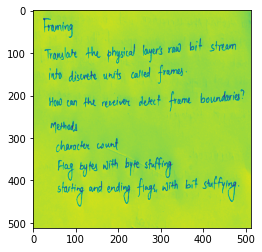

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Try_image.jpg')
image=cv2.resize(image,(512,512))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)
print(image.shape)

In [ ]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

#model = FCN(n_classes=2,  
            #  input_height=320, 
            #  input_width=320)
model=unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
random.shuffle(image_list)
file_train=image_list[0:int(0.9*len(image_list))]
file_test=image_list[int(0.1*len(image_list)):]

In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('/content/drive/MyDrive/weights{epoch:08d}.h5', 
                                     save_weights_only=True, save_freq=1)
history = model.fit(batch_generator(file_train,2),epochs=12,steps_per_epoch=200,validation_data=batch_generator(file_test,2),
                    validation_steps=400,callbacks=[mc],shuffle=1)

Epoch 1/12
200/200 [==============================] - 377s 2s/step - loss: 0.1711 - accuracy: 0.9330 - val_loss: 0.1378 - val_accuracy: 0.9426
Epoch 2/12
200/200 [==============================] - 349s 2s/step - loss: 0.1137 - accuracy: 0.9514 - val_loss: 0.1115 - val_accuracy: 0.9529
Epoch 3/12
200/200 [==============================] - 393s 2s/step - loss: 0.1037 - accuracy: 0.9563 - val_loss: 0.1030 - val_accuracy: 0.9566
Epoch 4/12
200/200 [==============================] - 560s 3s/step - loss: 0.0986 - accuracy: 0.9577 - val_loss: 0.0929 - val_accuracy: 0.9602
Epoch 5/12
200/200 [==============================] - 571s 3s/step - loss: 0.0912 - accuracy: 0.9605 - val_loss: 0.0872 - val_accuracy: 0.9626
Epoch 6/12
200/200 [==============================] - 565s 3s/step - loss: 0.0882 - accuracy: 0.9619 - val_loss: 0.0859 - val_accuracy: 0.9631
Epoch 7/12
200/200 [==============================] - 551s 3s/step - loss: 0.0824 - accuracy: 0.9642 - val_loss: 0.0807 - val_accuracy: 0.9654

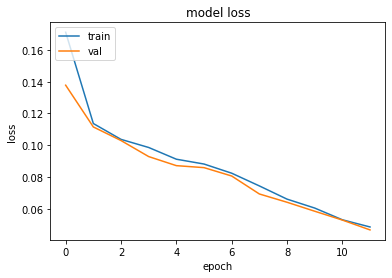

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

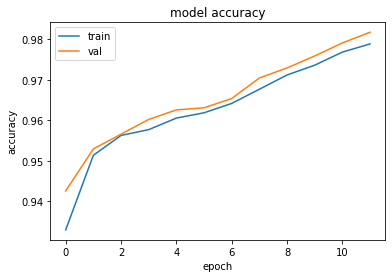

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/unet3.h5')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/unet3.h5')

In [ ]:
test_img_path = '/content/drive/MyDrive/Test_img7.jpg'

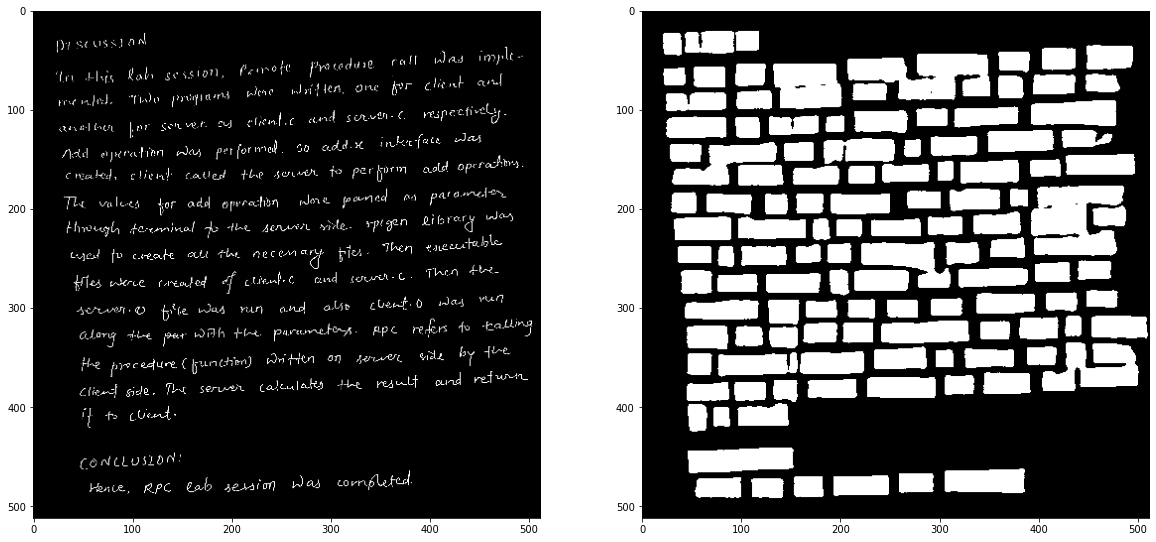

In [ ]:
img=cv2.imread(test_img_path, 0)
img = cv2.GaussianBlur(img, (9, 9), 0)

# ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 10)
# ret,img=cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
img=cv2.resize(img,(512,512))
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img, cmap = 'gray')
img= np.expand_dims(img,axis=-1)
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.subplot(122)
plt.imshow(pred,cmap='gray')
plt.imsave('test_img_mask.JPG',pred)

[[110, 472, 143, 492], [53, 471, 100, 492], [153, 470, 183, 491], [193, 469, 249, 490], [259, 467, 294, 487], [305, 462, 386, 487], [46, 441, 153, 467], [72, 400, 89, 420], [46, 397, 66, 425], [96, 396, 148, 419], [93, 375, 125, 394], [45, 375, 88, 394], [132, 373, 157, 395], [167, 372, 217, 391], [227, 370, 296, 391], [305, 368, 335, 388], [344, 365, 392, 387], [45, 346, 71, 368], [76, 345, 157, 370], [159, 344, 224, 367], [296, 342, 314, 360], [325, 341, 375, 361], [388, 339, 418, 358], [234, 339, 287, 362], [403, 335, 501, 384], [128, 319, 157, 341], [94, 318, 122, 339], [45, 318, 87, 342], [202, 315, 233, 336], [162, 315, 197, 336], [341, 313, 371, 332], [241, 313, 330, 336], [380, 309, 420, 332], [453, 308, 510, 331], [426, 308, 443, 329], [247, 292, 278, 310], [165, 292, 197, 310], [127, 292, 159, 317], [43, 292, 118, 312], [207, 291, 235, 311], [291, 290, 323, 308], [337, 285, 396, 306], [407, 284, 439, 304], [448, 282, 480, 300], [76, 266, 117, 284], [125, 265, 180, 285], [214,

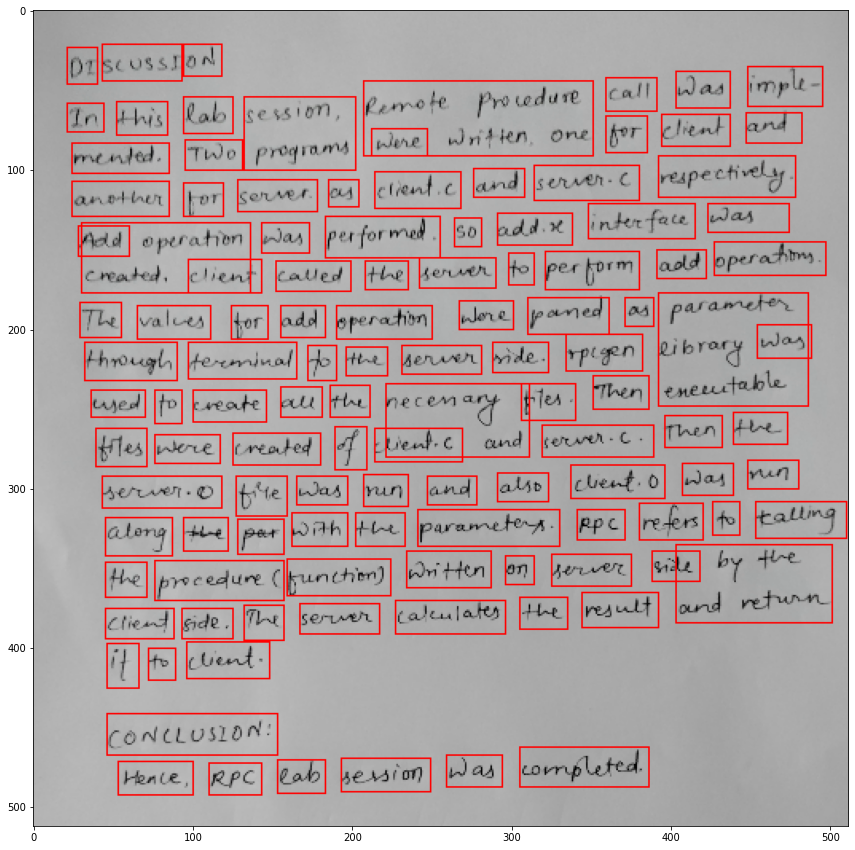

In [ ]:
img = cv2.imread('/content/test_img_mask.JPG',0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread(test_img_path)
ori_img=cv2.resize(ori_img,(512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
coordinates = []
for c in contours:
    # get the bounding rect
    # print(c)
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(ori_img, (x, y), (x+w,y+h), 255, 1)
    coordinates.append([x,y,(x+w),(y+h)])

cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
print(coordinates)
plt.figure(figsize=(15,15))
plt.imshow(ori_img)